
## Montando o Google Drive e Configurando os Caminhos


In [ ]:
from google.colab import drive
import os
import time

# Inicia o cronômetro
start_time_total = time.time()

drive.mount('/content/drive')

# Caminhos
# base_path = "/content/drive/MyDrive/Datasets_Scalograms/CMorl"
# base_path = "/content/drive/MyDrive/Datasets_Scalograms/MexicanHat"
base_path = "/content/drive/MyDrive/Datasets_Scalograms/Morl"

# Criar uma nova pasta para os resultados
results_path_mobilenet = os.path.join(base_path, "Training_Results_MobileNet_Accuracy")
os.makedirs(results_path_mobilenet, exist_ok=True)

train_dir = os.path.join(base_path, 'training')
val_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'testing')

# Verificando se os diretórios de treinamento, validação e teste existem
for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Diretório não encontrado: {path}")

Mounted at /content/drive


In [ ]:
!pip install tensorflow


## Configurando os Parâmetros e Criando os Geradores de Dados


In [ ]:
# Configurando os Parâmetros e Criando os Geradores de Dados

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resolução de imagem e batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data augmentation (apenas reescala)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 13956 images belonging to 2 classes.
Found 2826 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.



## Construindo o Modelo e Compilando para a Etapa 1

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

# Carregando MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# --- ETAPA 1: Congelar a base convolucional ---
base_model.trainable = False

# Montando o modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilando o modelo para a Etapa 1
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc_roc')])

print("--- Sumário do Modelo para a Etapa 1 (Base Congelada) ---")
model.summary()

--- Sumário do Modelo para a Etapa 1 (Base Congelada) ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,705 (12.82 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 3,229,120 (12.32 MB)


## Etapa 1 - Treinamento do Classificador (Base Congelada)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks para a Etapa 1 (monitorando acurácia)
early_stopping_s1 = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

checkpoint_path_s1 = os.path.join(results_path_mobilenet, "mobilenet_stage1_best.keras")
model_checkpoint_s1 = ModelCheckpoint(filepath=checkpoint_path_s1,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)

# Treinamento da Etapa 1
print("\n--- Iniciando Treinamento da Etapa 1: Apenas o Classificador ---")
history_stage1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping_s1, model_checkpoint_s1],
    verbose=1
)


--- Iniciando Treinamento da Etapa 1: Apenas o Classificador ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 5165s 12s/step - accuracy: 0.7738 - auc_roc: 0.8479 - loss: 0.4939 - precision: 0.7796 - recall: 0.7618 - val_accuracy: 0.8776 - val_auc_roc: 0.9437 - val_loss: 0.3047 - val_precision: 0.8880 - val_recall: 0.8641
Epoch 2/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 235s 537ms/step - accuracy: 0.8693 - auc_roc: 0.9434 - loss: 0.3023 - precision: 0.8755 - recall: 0.8583 - val_accuracy: 0.8868 - val_auc_roc: 0.9495 - val_loss: 0.2887 - val_precision: 0.8918 - val_recall: 0.8804
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 235s 538ms/step - accuracy: 0.8748 - auc_roc: 0.9481 - loss: 0.2895 - precision: 0.8852 - recall: 0.8635 - val_accuracy: 0.8864 - val_auc_roc: 0.9511 - val_loss: 0.2827 - val_precision: 0.8917 - val_recall: 0.8797
Epoch 4/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 234s 536ms/step - accuracy: 0.8840 - auc_roc: 0.9533 - loss: 0.2742 - precision: 0.8914 - recall: 0.8750 - val_accuracy: 0.8832 - val_auc_roc: 0.9506 - val_loss: 0.2881 - val_precision: 0.8706 - val_


## Configurando para a Etapa 2 - Fine-Tuning


In [ ]:
# --- ETAPA 2: Descongelar camadas para o Fine-Tuning ---
print("\n--- Configurando para a Etapa 2: Fine-Tuning ---")

# Descongelar a base para permitir o ajuste fino
base_model.trainable = True

# Manter as camadas inferiores congeladas e descongelar as 30 superiores
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar o modelo com uma taxa de aprendizado muito baixa
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer_fine_tune,
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc_roc')])

print("\n--- Sumário do Modelo para a Etapa 2 (Fine-Tuning) ---")
model.summary()


--- Configurando para a Etapa 2: Fine-Tuning ---

--- Sumário do Modelo para a Etapa 2 (Fine-Tuning) ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,705 (12.82 MB)

 Trainable params: 2,527,233 (9.64 MB)

 Non-trainable params: 833,472 (3.18 MB)

##  Etapa 2 - Treinamento de Fine-Tuning

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks para a Etapa 2 de Fine-Tuning (monitorando acurácia)
early_stopping_s2 = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)

checkpoint_path_s2 = os.path.join(results_path_mobilenet, "mobilenet_best_finetuned.keras")
model_checkpoint_s2 = ModelCheckpoint(filepath=checkpoint_path_s2,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=3, min_lr=1e-7)

# Continuar o treinamento de onde parou
initial_epoch_s2 = len(history_stage1.history['loss'])
total_epochs = 50

print("\n--- Iniciando Treinamento da Etapa 2: Fine-Tuning ---")
history_stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch_s2,
    callbacks=[early_stopping_s2, model_checkpoint_s2, reduce_lr],
    verbose=1
)


--- Iniciando Treinamento da Etapa 2: Fine-Tuning ---
Epoch 8/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 251s 566ms/step - accuracy: 0.7548 - auc_roc: 0.8367 - loss: 0.6143 - precision: 0.7311 - recall: 0.8100 - val_accuracy: 0.8369 - val_auc_roc: 0.9338 - val_loss: 0.3890 - val_precision: 0.7847 - val_recall: 0.9285 - learning_rate: 1.0000e-05
Epoch 9/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 246s 562ms/step - accuracy: 0.8650 - auc_roc: 0.9451 - loss: 0.3066 - precision: 0.8427 - recall: 0.8894 - val_accuracy: 0.8910 - val_auc_roc: 0.9593 - val_loss: 0.2658 - val_precision: 0.8711 - val_recall: 0.9179 - learning_rate: 1.0000e-05
Epoch 10/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 246s 563ms/step - accuracy: 0.9062 - auc_roc: 0.9692 - loss: 0.2270 - precision: 0.8954 - recall: 0.9184 - val_accuracy: 0.9034 - val_auc_roc: 0.9689 - val_loss: 0.2521 - val_precision: 0.9545 - val_recall: 0.8471 - learning_rate: 1.0000e-05
Epoch 11/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 246s 563ms/step - accuracy: 0.9326 - auc_roc: 0.9813 - lo

## Combinando Históricos, Avaliação Final e Salvamento em JSON




In [ ]:
import json
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)

# --- AVALIAÇÃO FINAL ---

# 1. Carregar o melhor modelo salvo pelo ModelCheckpoint para a avaliação final
# (Este é o modelo com a maior acurácia de validação durante o fine-tuning)
print(f"\nCarregando o melhor modelo salvo em: {checkpoint_path_s2}")
model.load_weights(checkpoint_path_s2)

# 2. Avaliação no conjunto de teste com o modelo carregado
print("\nAvaliando o melhor modelo no conjunto de teste...")
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 3. Cálculo das métricas de teste
acc_test = np.mean(y_pred == y_true)
precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
f1_test = f1_score(y_true, y_pred)
auc_roc_test = roc_auc_score(y_true, y_pred_probs)

evaluation_test_metrics = {
    "accuracy_test": round(acc_test, 4),
    "precision_test": round(precision_test, 4),
    "recall_test": round(recall_test, 4),
    "f1_score_test": round(f1_test, 4),
    "auc_roc_test": round(auc_roc_test, 4)
}

# 4. Combinar os históricos das duas etapas para plotagem e salvamento
combined_history = {}
for key in history_stage1.history.keys():
    combined_history[key] = history_stage1.history[key] + history_stage2.history[key]

rounded_combined_history = {
    key: [round(v, 4) for v in values]
    for key, values in combined_history.items()
}

final_log_to_save = rounded_combined_history.copy()
final_log_to_save['evaluation_on_test_set'] = evaluation_test_metrics

history_path = os.path.join(results_path_mobilenet, "training_history_mobilenet.json")
with open(history_path, 'w') as f:
    json.dump(final_log_to_save, f, indent=4)
print(f"\nHistórico e métricas salvos em: {history_path}")

# 5. Calcular e imprimir o tempo total de execução
end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
hours = int(total_execution_time // 3600)
minutes = int((total_execution_time % 3600) // 60)
seconds = int(total_execution_time % 60)
print(f"\nTempo total de execução do notebook: {hours:02d}:{minutes:02d}:{seconds:02d}")



Carregando o melhor modelo salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/mobilenet_best_finetuned.keras

Avaliando o melhor modelo no conjunto de teste...
34/34 ━━━━━━━━━━━━━━━━━━━━ 544s 16s/step

Histórico e métricas salvos em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/training_history_mobilenet.json

Tempo total de execução do notebook: 04:13:19


 ## Exibição das Métricas de Avaliação do Conjunto de Teste

In [ ]:
# Exibindo as métricas de teste
print(f"\n🔍 Avaliação do Modelo no conjunto de teste:")
print(f"Acurácia:   {acc_test:.4f}")
print(f"Precisão:   {precision_test:.4f}")
print(f"Revocação:  {recall_test:.4f}")
print(f"F1-Score:   {f1_test:.4f}")
print(f"AUC-ROC:    {auc_roc_test:.4f}")


🔍 Avaliação do Modelo no conjunto de teste:
Acurácia:   0.8401
Precisão:   0.8304
Revocação:  0.8548
F1-Score:   0.8424
AUC-ROC:    0.9149


## Exibição do Classification Report

In [ ]:
# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Negativo', 'Positivo']))


📄 Classification Report:
              precision    recall  f1-score   support

    Negativo       0.85      0.83      0.84       544
    Positivo       0.83      0.85      0.84       544

    accuracy                           0.84      1088
   macro avg       0.84      0.84      0.84      1088
weighted avg       0.84      0.84      0.84      1088



## Plotando Gráficos Individuais do Histórico

Gráfico de Acurácia salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/accuracy_plot.png


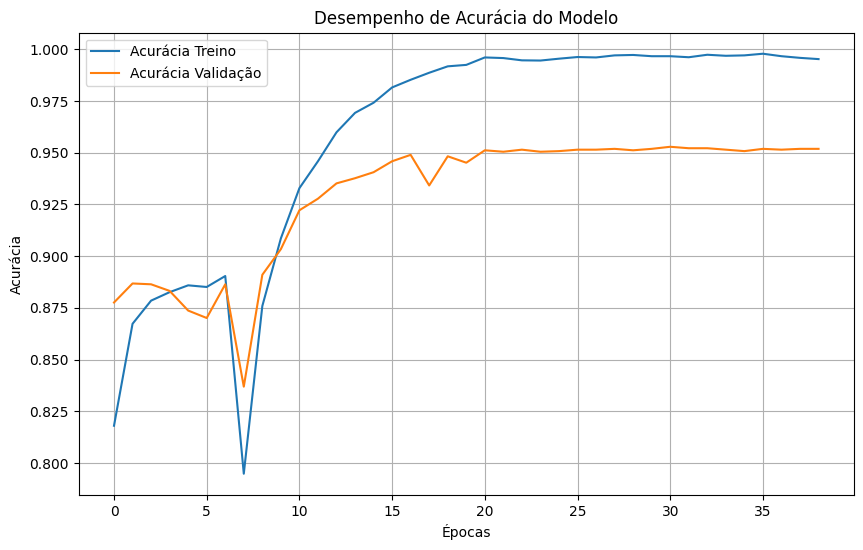

Gráfico de Precisão salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/precision_plot.png


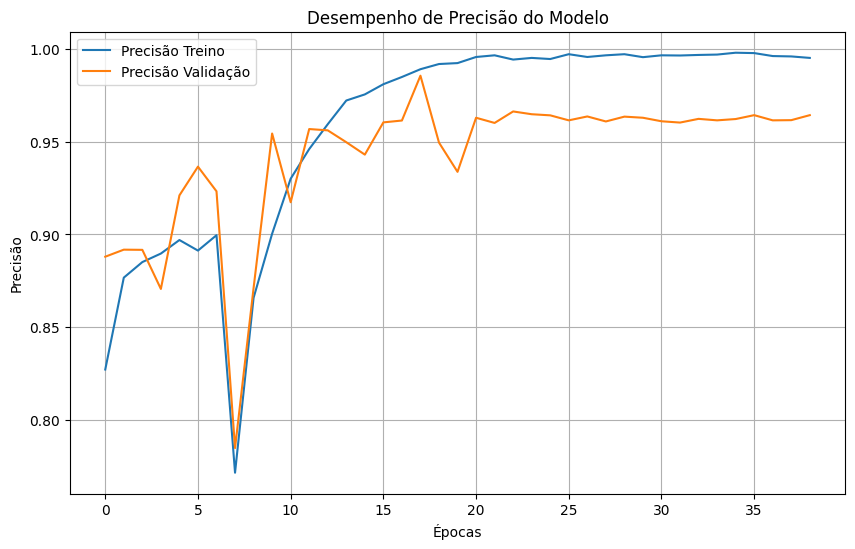

Gráfico de Revocação (Recall) salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/recall_plot.png


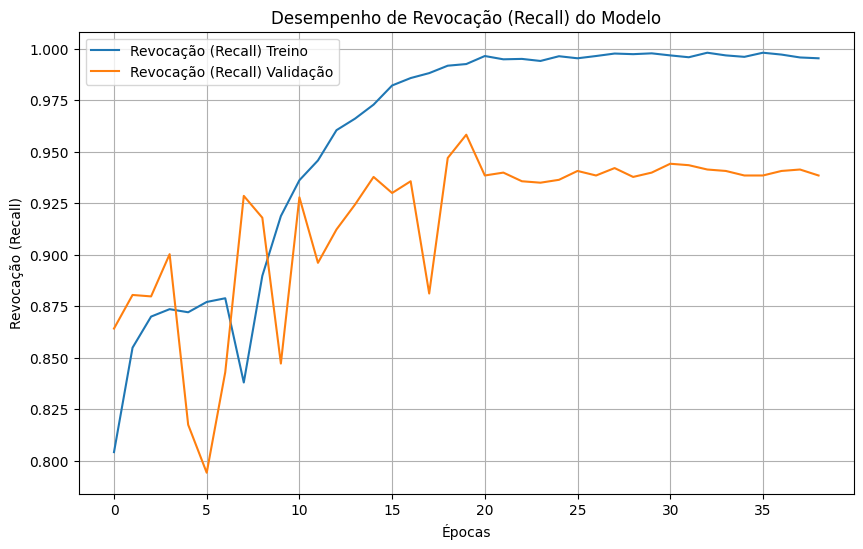

Gráfico de AUC-ROC salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/auc_roc_plot.png


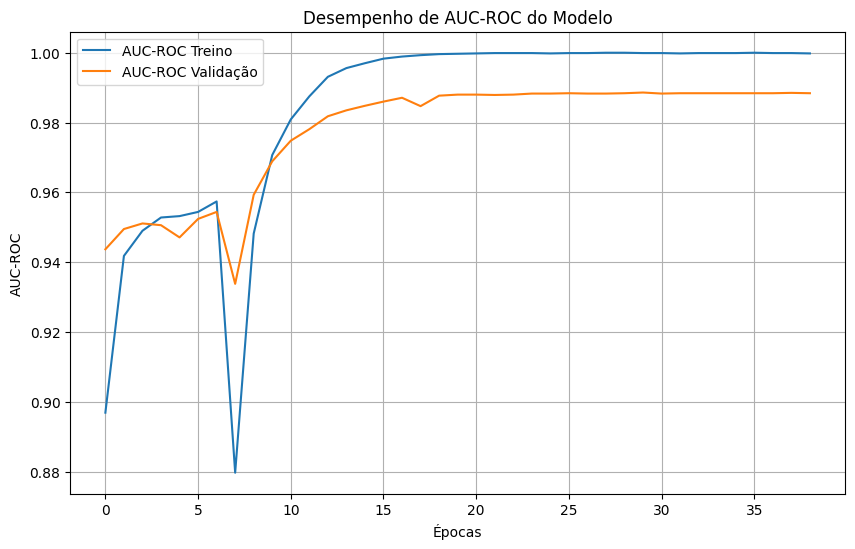

Gráfico de Perda (Loss) salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/loss_plot.png


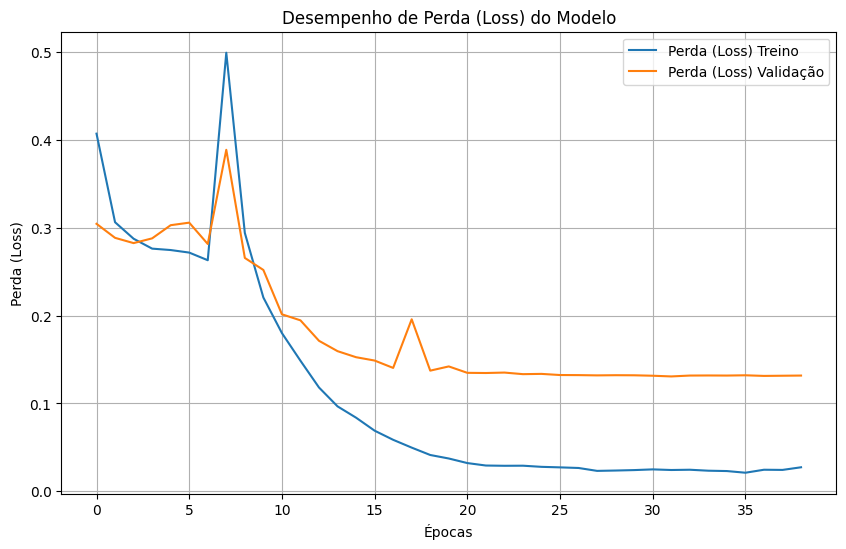

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

history_data = rounded_combined_history
base_results_path = results_path_mobilenet

def plot_metric(metric_key, metric_name):
    plt.figure(figsize=(10, 6))
    if metric_key in history_data:
        plt.plot(history_data[metric_key], label=f'{metric_name} Treino')
    if f'val_{metric_key}' in history_data:
        plt.plot(history_data[f'val_{metric_key}'], label=f'{metric_name} Validação')
    plt.title(f'Desempenho de {metric_name} do Modelo')
    plt.xlabel('Épocas')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_results_path, f"{metric_key}_plot.png"))
    print(f"Gráfico de {metric_name} salvo em: {os.path.join(base_results_path, f'{metric_key}_plot.png')}")
    plt.show()
    plt.close()

# Plotando todas as métricas
plot_metric('accuracy', 'Acurácia')
plot_metric('precision', 'Precisão')
plot_metric('recall', 'Revocação (Recall)')
plot_metric('auc_roc', 'AUC-ROC')
plot_metric('loss', 'Perda (Loss)')

## Plotando Gráficos do Histórico de Treinamento

## Plotando Matriz de Confusão

Gráfico da Matriz de Confusão salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/confusion_matrix.png


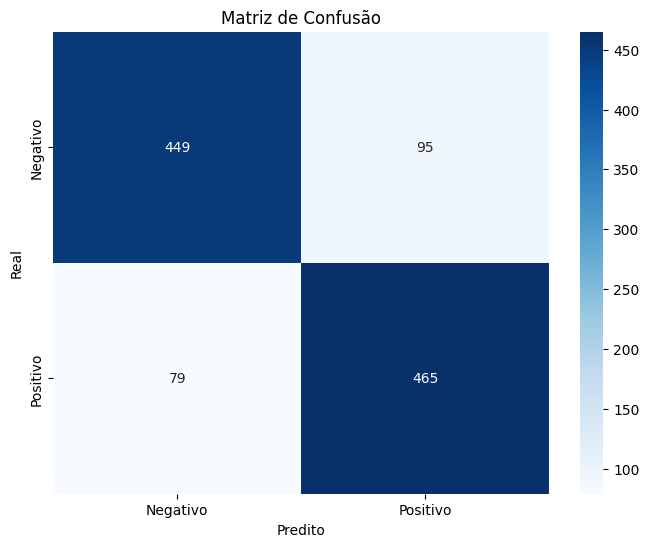

Gráfico da Matriz de Confusão Normalizada salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/confusion_matrix_normalized.png


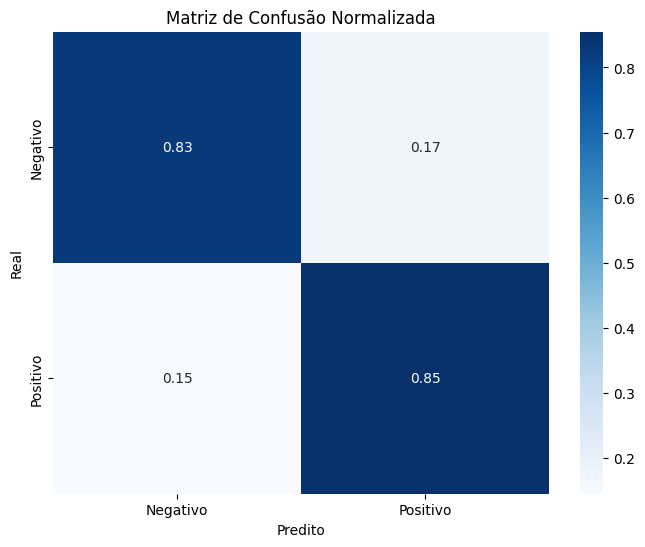

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.savefig(os.path.join(base_results_path, "confusion_matrix.png"))
print(f"Gráfico da Matriz de Confusão salvo em: {os.path.join(base_results_path, 'confusion_matrix.png')}")
plt.show()
plt.close()

# Matriz de Confusão Normalizada
conf_matrix_norm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão Normalizada')
plt.savefig(os.path.join(base_results_path, "confusion_matrix_normalized.png"))
print(f"Gráfico da Matriz de Confusão Normalizada salvo em: {os.path.join(base_results_path, 'confusion_matrix_normalized.png')}")
plt.show()
plt.close()

## Plotando Curva ROC

Gráfico da Curva ROC salvo em: /content/drive/MyDrive/Datasets_Scalograms/Morl/Training_Results_MobileNet_Accuracy/roc_curve.png


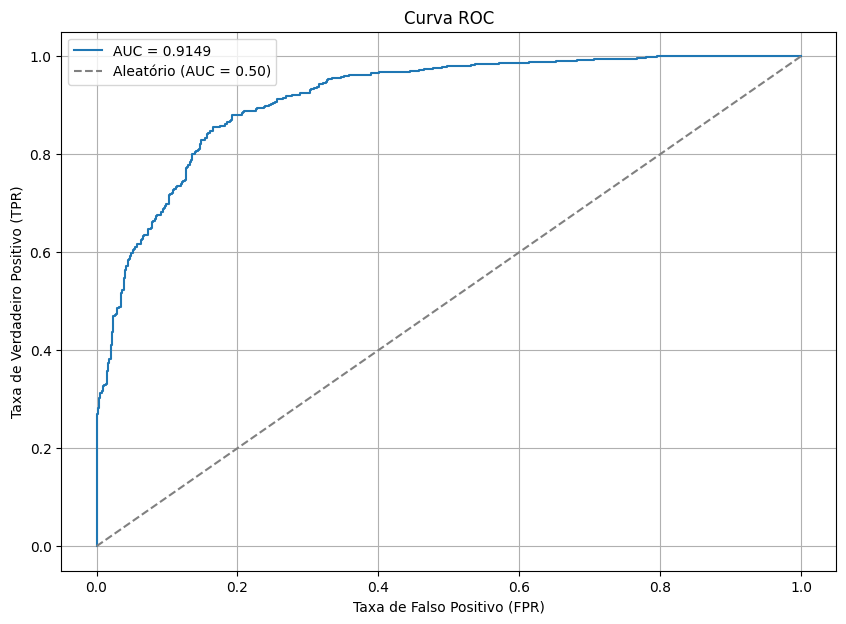

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc_test:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório (AUC = 0.50)')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_results_path, "roc_curve.png"))
print(f"Gráfico da Curva ROC salvo em: {os.path.join(base_results_path, 'roc_curve.png')}")
plt.show()
plt.close()